<a href="https://colab.research.google.com/github/msc-acse/acse-9-independent-research-project-Garethlomax/blob/baseline_hybrid/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTS

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# !ls

%cd /content/drive/My \Drive/masters_project/python_modules/MovingMNIST-master

# all torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.transforms as transforms
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from torchvision import models

import matplotlib.pyplot as plt
import h5py

# importing moving mnist test set.
from MovingMNIST import MovingMNIST

%cd /content/drive/My \Drive/masters_project/python_modules/pytorch-summary-master
from torchsummary import summary

# %cd /content/drive/My \Drive/masters_project/python_modules/pytorch_modelsize-master

%cd /content/drive/My \Drive/masters_project/python_modules/pytorchvis-master

!pip install torchviz

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True




/content/drive/My Drive/masters_project/python_modules/MovingMNIST-master
/content/drive/My Drive/masters_project/python_modules/pytorch-summary-master
[Errno 2] No such file or directory: '/content/drive/My Drive/masters_project/python_modules/pytorchvis-master'
/content/drive/My Drive/masters_project/python_modules/pytorch-summary-master


## cuda code

In [23]:

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")
    
    
import random
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = True

    return True
  
set_seed(42)

Cuda installed! Running on GPU!


True

# MODEL 

In [0]:
# alex_net = models.A
# alex = models.alexnet(pretrained = True)

# # make conditioned - give the decoder the last output of encoder as input.
# class Enc_Dec(nn.Module):
#     def __init__(self):
#         super(Enc_Dec, self).__init__()
        
#         self.

In [0]:
# alex.features[0] = nn.Conv2d(1,64, kernel_size = (11,11), stride = (4,4), padding = (2,2))
# for i, params in enumerate(alex.parameters()):
#     if (i==1):
#         print(params.data)



# Encoder
NON VARIATIONAL

In [0]:
class encoder(nn.Module):
    def __init__(self, in_channels, image_dims):
        super(encoder, self).__init__()
        self.image_dims = image_dims # list of channels, height, width
        self.in_chan = in_channels
        
        """activations """
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()
        
        
        # need to decide how deep the input is
        """convolution encoding """
        self.c1 = nn.Conv2d(self.in_chan, 32, kernel_size = 4, stride = 2)
        
        self.c2 = nn.Conv2d(32, 64, kernel_size = 4, stride = 2)
        
        self.c3 = nn.Conv2d(64, 128, kernel_size = 4, stride = 2)
        
        self.c4 = nn.Conv2d(128, 256, kernel_size = 4, stride = 2)
        
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()
        
        """ fully connected layer """
        
        self.fc1 = nn.Linear(1024,128)
        
        self.fc2 = nn.Linear(128,1024)
        
        self.fc3 = nn.Linear(1024,1024) # get rid of this one
        
        """ decoder convolution"""
        # why does not having equal kernel sizes as above not effect it in this way?
        
        self.t1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=1)
        
        self.t2 = nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2)
        
        self.t3 = nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2)
        
        self.t4 = nn.ConvTranspose2d(32, self.in_chan, kernel_size=6, stride=2)
        
#         self.t1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding = 2)
        
#         self.t2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2)
        
#         self.t3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2)
        
#         self.t4 = nn.ConvTranspose2d(32, self.in_chan, kernel_size=4, stride=2)
        
    
    def encode(self, x):
        x = self.relu(self.c1(x))
        x = self.relu(self.c2(x))
        x = self.relu(self.c3(x))
        x = self.relu(self.c4(x))
        return x
    
    def fc_layers(self, x):
        #first we flatten
        # -1 in pytorch view is the same as -1 in numpy reshape
        x = x.view(x.size(0), -1) # using view terminology
        
        # fully connected layers
        # this is an autoencoder with no variation, so no distribution sampling
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x) # get rid of this layer.
        # x.size(0) allows for variable batch sizes.
        size = 256 # size of flattened array going in?
        x = x.view(x.size(0), size, 2, 2)
#         x = x.view(-1, self.image_dims[0], self.image_dims[1], self.image_dims[2])
        
        # now we reshape the image back into the square. 
        return x
    
    def decode(self, x):
#         print(x.shape)
        dummy = torch.randn([1,1,64,64])
        x = self.relu(self.t1(x))
        x = self.relu(self.t2(x))
        x = self.relu(self.t3(x))
        x = self.relu(self.t4(x, output_size = dummy.size())) #  output_size = dummy.size())
        return x
        
    def forward(self, x):
        x = self.encode(x)
        x = self.fc_layers(x)
        x = self.decode(x)
        x = self.sig(x)
        return x
    
        
        
    
        
        
        
        
        
        
        

In [0]:
x = torch.randn([1,1,64,64])


In [0]:
test = encoder(1, [1,64,64]).double()


In [0]:
# test

In [677]:
test.eval()

encoder(
  (relu): ReLU()
  (sig): Sigmoid()
  (c1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2))
  (c2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (c3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
  (c4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (t1): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
  (t2): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
  (t3): ConvTranspose2d(64, 32, kernel_size=(6, 6), stride=(2, 2))
  (t4): ConvTranspose2d(32, 1, kernel_size=(6, 6), stride=(2, 2))
)

## troubleshooting

torch.float64
torch.Size([1, 1, 64, 64])
tensor(0.5382, dtype=torch.float64)
torch.Size([1, 256, 2, 2])
torch.Size([1, 1, 64, 64])


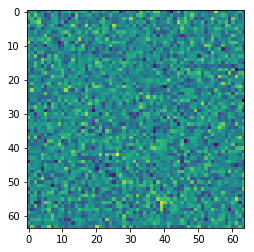

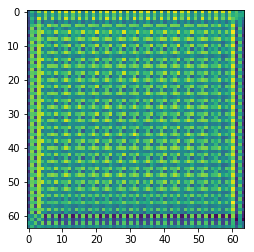

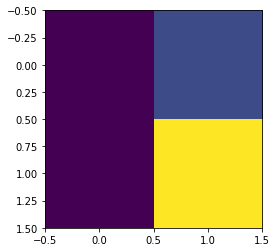

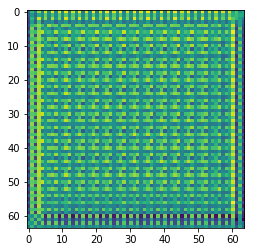

In [678]:
plt.imshow(x[0][0])
plt.figure()
with torch.no_grad():
    x = x.double()
#     print(test.type)
    out = test(x)
#     out.detatch()
    print(out.dtype)
    plt.imshow(out[0][0])
    print(out.shape)
    # why are all these values 0.5?
    
    print(out[0][0][4][14])
    out1 = test.encode(x)
    print(out1.shape)
    plt.figure()
    plt.imshow(out1[0][0])
    # decode now
    plt.figure()
    out2 = test.decode(out1)
    print(out2.shape)
    plt.imshow(out2[0][0])

# Modified moving MNIST dataset


In [0]:
class HDF5Dataset_randn(Dataset):
    """dataset wrapper for hdf5 dataset to allow for lazy loading of data. This 
    allows ram to be conserved. 
    
    As the hdf5 dataset is not partitioned into test and validation, the dataset 
    takes a shuffled list of indices to allow specification of training and 
    validation sets.
    
    MAKE SURE TO CALL DEL ON GENERATED OBJECTS OTHERWISE WE WILL CLOG UP RAM
    
    """
    
    def __init__(self, path, index_map, transform = None):
        
        %cd /content/drive/My \Drive/masters_project/data 
        # changes directory to the one where needed.
        
        self.path = path
        
        self.index_map = index_map # maps to the index in the validation split
        # due to hdf5 lazy loading index map must be in ascending order.
        # this may be an issue as we should shuffle our dataset.
        # this will be raised as an issue as we consider a work around.
        # we should keep index map shuffled, and take the selection from the 
        # shuffled map and select in ascending order. 
        
        
        self.file = h5py.File(path, 'r')
        
        
        
        
        
        
    def __len__(self):
        return len(self.index_map)
    
    def __getitem__(self,i):
        
        i = self.index_map[i] # index maps from validation set to select new orders
#         print(i)
        if isinstance(i, list): # if i is a list. 
            i.sort() # sorts into ascending order as specified above
            
        """TODO: CHECK IF THIS RETURNS DOUBLE"""
        
        # random index for subsampling. 
        rand_index = np.random.randint(10) # random index 0 - 9
        
#         predictor = torch.tensor(self.file["predictor"][i])
        
        truth = torch.tensor(self.file["truth"][i,rand_index]) # change to fancy indexing. 
        
        return truth

In [0]:
def initialise_dataset_HDF5_randn(dataset_length = 9000):
    """
    Returns datasets for training and validation. 
    
    Loads in datasets segmenting for validation fractions.
   
    
    
    """
    dummy = np.array(range(dataset_length)) # clean this up - not really needed
    
    
    
    train_dataset = HDF5Dataset_randn("train_set.hdf5", index_map = dummy)

    
    return train_dataset
        


In [0]:
# dat = initialise_dataset_HDF5_randn()



In [0]:
# # plt.imshow(dat[0:3][0][0])
# with torch.no_grad():
#     out = test(dat[0:1])
# #     out.detatch()
#     plt.imshow(out[0][0])
#     print(out.shape)
#     # why are all these values 0.5?
    
#     print(out[0][0][4][14])

# TRAINING FUNCTIONS

In [0]:
def train(model, optimizer, data_loader, loss_func):
    model.train()
    loss_tot = 0
    for x in data_loader:
        x = x.to(device)
        optimizer.zero_grad()
        pred = model(x)
        
        loss = loss_func(pred, x)
        loss.backward()
        loss_tot += loss
        optimizer.step()
    return loss_tot / 9000

def train_full(batch_size, epochs = 300):
    model = (encoder(1, [1,64,64]).double()).to(device)
    optimizer = torch.optim.Adam(model.parameters()) # default learning rate
    
    dataset = initialise_dataset_HDF5_randn()
    
    dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True)
    
    loss_func = nn.BCELoss()
#     loss_func = nn.BCELoss() not working for some reason. 
    
    print("TRAINING START")
    
    for epoch in range(epochs):
        loss_val = train(model, optimizer, dataloader, loss_func)
        torch.save(optimizer.state_dict(), F"Adam_encoder"+str(epoch)+".pth")
        torch.save(model.state_dict(), F"encoder_"+str(epoch)+".pth")
        
        print("ENCODER LOSS:" , loss_val)
        
    
    return model


In [683]:
device


'cuda'

In [0]:
enc = train_full(batch_size = 128)